## Homework 1c: Large Language Model Inference

Modern language models are often trained on hundreds of gigabytes of data and can't be easily replicated as a course project. In this assignment, we'll show how to use existing pre-trained transformer language models with the Python [`transformers` library](https://huggingface.co/docs/transformers/index).

In [9]:
# This block handles some basic setup and data loading.  
# You shouldn't need to edit this, but if you want to 
# import other standard python packages, that is fine.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext.legacy as torchtext

# download and load the data
text_field = torchtext.data.Field()
datasets = torchtext.datasets.WikiText2.splits(root='.', text_field=text_field)
train_dataset, validation_dataset, test_dataset = datasets

text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

train_text = train_dataset.examples[0].text # a list of tokens (strings)
validation_text = validation_dataset.examples[0].text

In [10]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(r-a)

0


### Inference with Autoregressive Models

We'll start by computing word probabilities under the autoregressive [GPT-2 model](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). To do so, we'll install the `transformers` library, which isn't natively installed on Google Colaboratory. We'll import a pre-trained `GPT2LMHeadModel` and its corresponding tokenizer, `GPT2TokenizerFast`. Note that without additional training, you can't freely mix-and-match models and their corresponding tokenizers! We aren't using the largest available models, such as [GPT-3](https://arxiv.org/abs/2005.14165), because they do not provide free inference. Larger freely available models such as [GPT-J](https://huggingface.co/EleutherAI/gpt-j-6B) do exist though, and you should feel free to play around with them.

In [11]:
!pip3 install transformers
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

The following code downloads model weights and can take a few minutes to run. For debugging purposes, feel free to swap out `gpt2-large` with a smaller model that downloads faster, but please submit your results using the `gpt2-large` model.

In [12]:
if torch.cuda.is_available():
    device = "cuda"
    print("Running on GPU")
else:
    device = "cpu"
    print("Running on CPU")
model = GPT2LMHeadModel.from_pretrained("gpt2-large").to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2-large")

Running on GPU


We'll extract the vocabulary from the tokenizer so that we can easily see the words we're dealing with:

In [13]:
vocab_map = {}
vocab = tokenizer.vocab
for token in tqdm.tqdm(vocab):
    if token == "yes":
        print(vocab[token])
    if token == "no":
        print(vocab[token])
    idx = vocab[token]
    vocab_map[idx] = token

100%|██████████| 50257/50257 [00:00<00:00, 1861390.23it/s]

8505
3919


We can use our tokenizer to convert sentences into tensors and use `vocab_map` to see what indices of these tensors correspond to. This will show which words are broken into subwords by the GPT-2 tokenizer. Note that `<|endoftext|>` is equivalent to `<eos>` in the previous notebook:

In [ ]:
sentence = "<|endoftext|>I love LSTMs"
encodings = tokenizer(sentence, return_tensors='pt')
print(encodings["input_ids"])
print([vocab_map[int(idx)] for idx in encodings["input_ids"][0]])

tensor([[50256,    40,  1842,   406,  2257, 10128]])
['<|endoftext|>', 'I', 'Ġlove', 'ĠL', 'ST', 'Ms']


As we can see from the above example, rare words like "LSTMs" are broken into multiple subwords by the GPT-2 tokenizer. Additionally, note that the token "Ġ" corresponds to a blank space, so we can reconstruct word boundaries from the tokenizer outputs. Given a sentence, we'll now use GPT-2 to compute contextual word probabilities for every word. Some hints for doing this:


* Check the documentation for the GPT2LMHeadModel here: https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel
* Begin by adding the `<|endoftext|>` token and passing the sentence into the tokenizer, as shown above
* Compute word probabilities by taking `model(input_ids).logits`
* Then, you'll need to `softmax` and index into the logits using `torch.gather` (the hardest part)
* Finally, convert to word probabilities (rather than subword probabilities) using `vocab_map` and the "Ġ" token



In [14]:
# Input: sentence (a string)
# Output: a list of (word, probability) tuples
#         -> word (string)
#         -> probability (float)
def get_gpt_probs(sentence):
    #print(sentence)
    # YOUR CODE HERE
    words = []
    probs = []
    # BEGIN SOLUTION
    added_sentence = "<|endoftext|>" + sentence
    encodings = tokenizer(added_sentence, return_tensors='pt')
    for i in encodings:
        encodings[i] = encodings[i].cuda()
    idx = encodings["input_ids"][0].cuda()
    #print(idx, encodings)
    input_id = idx[:-1]
    output_id = idx[1:]
    logits = model(input_id).logits

    #print(logits)
    after_softmax = torch.softmax(logits, 1)
    #print(max(after_softmax[0]))
    #print(after_softmax.size())
    gathered_logits = -torch.log(torch.gather(after_softmax, 1, output_id.unsqueeze(1)))
    #print(gathered_logits)
    subword = [vocab_map[int(idx)] for idx in encodings["input_ids"][0]]
    #print(subword)
    
    subword = subword[1:]

    probs.append(gathered_logits[0].item())
    words.append(subword[0])

    for i in range(1, len(subword)):
        prob = gathered_logits[i].item()

        if subword[i][0] == "Ġ":

            probs.append(prob)
            words.append(subword[i])
        else:
            probs[-1] += prob
            words[-1] += subword[i]
    
    # END SOlUTION
    return [(word, prob) for word, prob in zip(words, probs)]
            
get_gpt_probs("The florist sent the flowers was pleased.")

[('The', 2.4790921211242676),
 ('Ġflorist', 13.309798449277878),
 ('Ġsent', 8.142409324645996),
 ('Ġthe', 2.3661890029907227),
 ('Ġflowers', 1.405616044998169),
 ('Ġwas', 9.130634307861328),
 ('Ġpleased.', 9.912347078323364)]

In [15]:
# To check that your implementation is roughly correct:
def compare_probs(predictions, gold):
  assert len(predictions) == len(gold)
  for x,y in zip(predictions, gold):
    assert np.abs(x[1]-y[1]) < 0.01
  print("Passed")

predictions = get_gpt_probs("The florist sent the flowers was pleased.")
gold = [('The', 2.4790916442871094), ('Ġflorist', 13.309800148010254), ('Ġsent', 8.14240837097168), ('Ġthe', 2.3661890029907227), ('Ġflowers', 1.4056150913238525), ('Ġwas', 9.130632400512695), ('Ġpleased.', 9.912347793579102)]
compare_probs(predictions, gold)

predictions = get_gpt_probs("I like LSTMs")
gold = [('I', 4.226133823394775), ('Ġlike', 5.041623115539551), ('ĠLSTMs', 17.857036590576172)]
compare_probs(predictions, gold)

Passed
Passed


In [39]:
def var_surprise(probs):
    prob_list = []
    
    for i in range(len(probs)):
        mu = 0
        y = i+1
        for j in range(i+1):
            mu += probs[j]
        mu = mu/y
        sum = 0
        for j in range(i+1):
            sum += (probs[j] - mu)**2
        sum  = sum/y
        prob_list.append(sum)
    return prob_list

def local_surprise(probs):
    prob_list = []
    last_prob = 0
    last_total = 0
    for i in range(len(probs)):
        y = i+1
        last_total = (probs[i] - last_prob)**2 + last_total
        last_prob = probs[i]
        prob_list.append(last_total/y)
    return prob_list


We wrote some plotting code so you can visualize these probabilities for individual sentences. Note that this code might break on unusually long sentences, but we've provided a couple of examples below:

[0.0, 29.326049891676664, 19.564363519975075, 20.576207981939294, 20.73553285646965, 19.069637884894227, 18.088890775746115]
[ 0.          0.         29.32604989 19.56436352 20.57620798 20.73553286
 19.06963788 18.08889078]


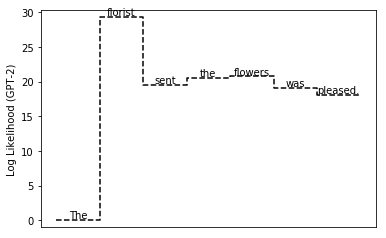

[0.0, 29.326049891676664, 19.564363519975075, 20.576207981939294, 20.73553285646965, 20.214424206099054, 17.363722761930696]
[ 0.          0.         29.32604989 19.56436352 20.57620798 20.73553286
 20.21442421 17.36372276]


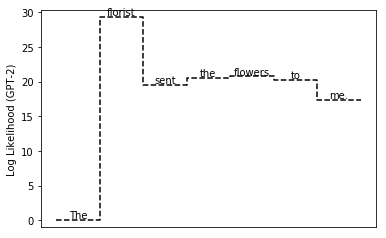

[0.0, 11.542124406515327, 19.250289286338116, 22.940240456294397]
[ 0.          0.         11.54212441 19.25028929 22.94024046]


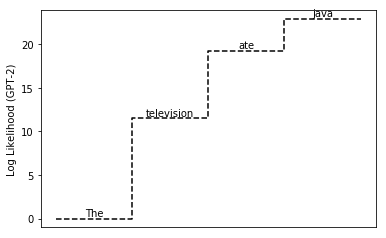

[6.14589774502042, 61.72504865586354, 50.05066922569697, 45.87918222034857, 36.887885857804164, 40.6858894084317, 34.96091590087052]
[ 6.14589775  6.14589775 61.72504866 50.05066923 45.87918222 36.88788586
 40.68588941 34.9609159 ]


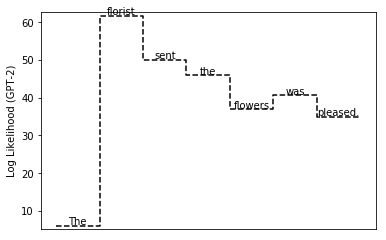

[6.14589774502042, 61.72504865586354, 50.05066922569697, 45.87918222034857, 36.887885857804164, 30.775448782284002, 29.12073199350912]
[ 6.14589775  6.14589775 61.72504866 50.05066923 45.87918222 36.88788586
 30.77544878 29.12073199]


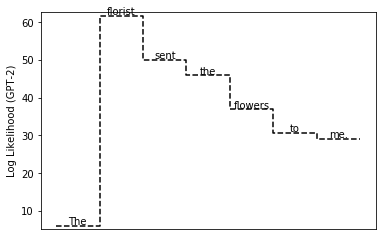

[6.1458918344056315, 26.15719473023347, 22.286301993540178, 17.642677499351436]
[ 6.14589183  6.14589183 26.15719473 22.28630199 17.6426775 ]


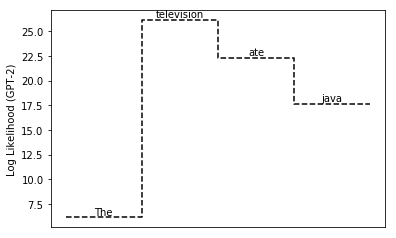

In [40]:
def plot_UID(sentence, surprise):
  words = sentence.split()
  probs = get_gpt_probs(sentence)
  assert len(words) == len(probs)
  probs = surprise([prob[1] for prob in probs])
  print(probs)
  probs = np.asarray([probs[0]] + probs)
  
  print(probs)
  #print(probs)
  x = np.arange(len(probs))
  plt.step(x, probs, where="pre", color="black", linestyle="dashed")
  text_x = (x[1:] + x[:-1])/2
  text_y = probs[1:] + 0.25
  #print(text_y)
  for idx in range(len(words)):
      plt.text(text_x[idx], text_y[idx], words[idx], ha="center")
  plt.ylim([min(probs)-1, max(probs)+1])
  plt.xticks()
  plt.ylabel("Log Likelihood (GPT-2)")
  plt.tick_params(
      axis='x', 
      which='both', 
      bottom=False, 
      top=False,
      labelbottom=False)
  plt.show()

plot_UID("The florist sent the flowers was pleased.", var_surprise)
plot_UID("The florist sent the flowers to me.", var_surprise)
plot_UID("The television ate java", var_surprise)
plot_UID("The florist sent the flowers was pleased.", local_surprise)
plot_UID("The florist sent the flowers to me.", local_surprise)
plot_UID("The television ate java", local_surprise)


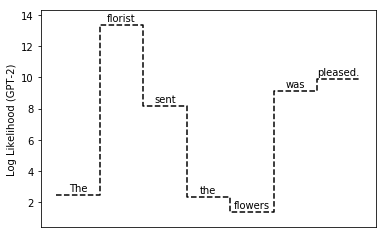

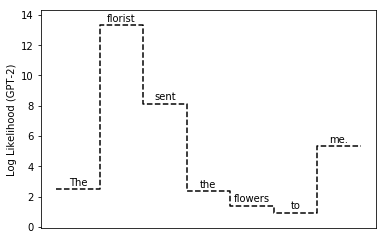

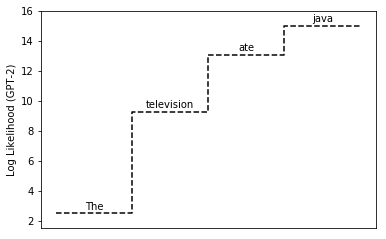

In [19]:
def plot_gpt_probs(sentence):
  words = sentence.split()
  probs = get_gpt_probs(sentence)
  assert len(words) == len(probs)
  probs = np.asarray([probs[0][1]] + [prob[1] for prob in probs])
  x = np.arange(len(probs))
  plt.step(x, probs, where="pre", color="black", linestyle="dashed")
  text_x = (x[1:] + x[:-1])/2
  text_y = probs[1:] + 0.25
  for idx in range(len(words)):
      plt.text(text_x[idx], text_y[idx], words[idx], ha="center")
  plt.ylim([min(probs)-1, max(probs)+1])
  plt.xticks()
  plt.ylabel("Log Likelihood (GPT-2)")
  plt.tick_params(
      axis='x', 
      which='both', 
      bottom=False, 
      top=False,
      labelbottom=False)
  plt.show()

plot_gpt_probs("The florist sent the flowers was pleased.")
plot_gpt_probs("The florist sent the flowers to me.")
plot_gpt_probs("The television ate java")

The first sentence above is an example of a [garden-path sentence](https://en.wikipedia.org/wiki/Garden-path_sentence). Even though it's a fairly common word, "was" is assigned low probability because it's unlikely in the context; other words like "florist" and "pleased" are also low probability, but they're rarer across all contexts they appear in (i.e., lower unigram probability). The second sentence shows a non-garden-path continuation with much higher probability.

One downside of transformer language models is that they have a fixed length, so [computing perplexity can be expensive](https://huggingface.co/transformers/v3.2.0/perplexity.html). Although using a sliding window is the most principled way to compute perplexity with GPT-2, [striding can also provide good results with faster inference](https://arxiv.org/pdf/2012.15832.pdf). Next, we'll modify our existing function to handle longer sequences. Our model has an effective context length of 1024 tokens, and we'll use a stride of 512. This means that every token will be predicted with at least 512 tokens in the context.

In [16]:
stride = 512
print("Context length: {}".format(model.config.n_positions))
import math

Context length: 1024


In [37]:
tokenizer("<|endoftext|>" + " Sentiment", return_tensors='pt')["input_ids"]

tensor([[50256, 11352,  3681]])

tensor([[11352,  3681]])

In [43]:
def get_gpt_probs(document, stride=512):
    # YOUR CODE HERE
    document = " ".join(document.split())
    document = "<|endoftext|>" + document
    encodings = tokenizer(document, return_tensors='pt')
    encod_ids = encodings["input_ids"][0]
    
    #print(encodings)
    words = [""]
    probs = [0]

    # BEGIN SOLUTION

    doc_len = len(encodings["input_ids"][0])
    encode_len = 2*stride
    stride = stride
    num_sentence = math.ceil((doc_len - encode_len)/stride) + 1
  
    sentences = []
    with torch.no_grad():
      for i in tqdm.tqdm_notebook(range(num_sentence)):
                
          start_idx = i*stride
          end_idx = min(start_idx + encode_len, doc_len - 1)
          idx = encod_ids[start_idx: end_idx].cuda()
          input_id = idx[:-1]
          if i == 0:
              output_id = idx[1:]
          else:
              output_id = idx[min(stride, len(idx)):]
          logits = model(input_id).logits
          idx.detach().cpu()          
          after_softmax = torch.softmax(logits, 1)          
          gathered_logits = -torch.log(torch.gather(after_softmax, 1, output_id.unsqueeze(1)))          
          subword = [vocab_map[int(idx)] for idx in output_id]          
          for i in range(len(subword)):
            prob = gathered_logits[i].item()
            # if subword[i][0] == "Ġ" and len(subword[i]) == 1:
            #     continue
            if subword[i][0] == "Ġ":
                probs.append(prob)
                words.append(subword[i])
            else:
                probs[-1] += prob
                words[-1] += subword[i]      
    # END SOlUTION
    result = [(word, prob) for word, prob in zip(words, probs)]
    #print(result)
    return result

We'll now compute the probabilities of every word in *Pride and Prejudice* using GPT-2. Note that this will take a very long time to run with a small stride, so you're encouraged to get the implementation of striding correct. You'll submit the output probabilities as `word_probs.npy`.

In [44]:
!wget https://cal-cs288.github.io/sp22/project_files/hw1/pride.txt
with open("pride.txt", "r", encoding="utf-8") as infile:
  text = infile.read()
output = get_gpt_probs(text, stride=512)
probs = np.asarray([val[1] for val in output])

np.save("word_probs.npy", probs)

'wget' is not recognized as an internal or external command,
operable program or batch file.
c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/316 [00:00<?, ?it/s]

In [45]:
print(len(probs), len(text))
print(len(text.split()))
word = np.asarray([val[0] for val in output])
print(word[-20:])

124467 773036
124467
['Ġhow' 'Ġto' 'Ġhelp' 'Ġproduce' 'Ġour' 'Ġnew' 'ĠeBooks,' 'Ġand' 'Ġhow'
 'Ġto' 'Ġsubscribe' 'Ġto' 'Ġour' 'Ġemail' 'Ġnewsletter' 'Ġto' 'Ġhear'
 'Ġabout' 'Ġnew' 'ĠeBooks']


### Prompting with Language Models

Language models can be coerced into performing a variety of different tasks via *prompting*, as shown in the [GPT-3 paper](https://arxiv.org/abs/2005.14165). At a high level, prompting involves putting a few training examples into the context of a model and then using next word prediction to predict labels. In this assignment, we'll use prompting and the GPT-2 Large model on the sentiment task SST-2. But first, we'll download the dataset:

In [10]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")

Reusing dataset glue (C:\Users\yangh\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 142.86it/s]


Now, it's time to write a prompt for sentiment prediction. Here's an example what a prompt might look like for the task of machine translation:


```
The French "Le Tea Party est atterré." in English is "The tea party is aghast"
The French "Cela est vraiment indispensable pour notre nation." in English is "This really is a must for our nation."
The French "Il va y avoir du changement dans la façon dont nous payons ces taxes." in English is "There is going to be a change in how we pay these taxes."
The French "La technologie est là pour le faire." in English is
```
The model would then predict the next tokens, hopefully resulting in an English translation of the final sentence. Note that these examples are all taken from the `wmt14` translation dataset. In our case, however, we'll be predicting sentiment, which is represented by a binary value in the Stanford Sentiment Treebank. To convert next-word predictions into a binary decision, we'll compute the probability of two words (e.g., "yes" vs. "no") and then choose our label based on whichever one has the highest probability. 

In [28]:
from six import ensure_str
def predict_sentiment(sentence):
  # YOUR CODE HERE
  # - Write a prompt using 3-5 example sentences
  # - Append the current example to the prompt, with a template
  # - Compare probabilities of possible next tokens to get a predicted label
  # - Warning: DO NOT TRAIN OR FINE-TUNE A MODEL FOR THIS ASSIGNMENT
  # BEGIN SOLUTION
  Prompts = """Input: The film is awful tawdry crummy trashy trash shit. Output: no.
  Input: The movie is terrible cheap sleazy trashy trash shit. Output: no. 
  Input: Beautiful, awesome, and amazing film.  Output: yes. 
  Input: The movie is terrific fantastic. Output: yes. 
  Input: I love this incredible marvelous wonderful movie. Output: yes. 
  """
  sentence = "Input: " + sentence + " Output: "
  input_sent = Prompts + sentence
  #print(input_sent)
  encodings = tokenizer(input_sent, return_tensors='pt')
  idx = encodings["input_ids"][0].cuda()
  #print(idx, encodings)
  input_id = idx
  logits = model(input_id).logits[-1]

  #print(logits)
  after_softmax = torch.softmax(logits, -1)
  #print(max(after_softmax[0]))
  #print(after_softmax.size())
  gathered_logits = -torch.log(after_softmax)
  yes, no = gathered_logits[8505], gathered_logits[3919]
  if yes < no :
    return 1
  else:
    return 0
  # END SOLUTION

num_correct = 0
for idx in tqdm.tqdm(range(1000)):
  example = dataset["train"][idx]
  #print(example)
  predicted_label = predict_sentiment(example["sentence"])
  if predicted_label == example["label"]:
    num_correct += 1



100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


In [29]:
vocab_map[3919]
print(sum(dataset["train"]['label'])/ len(dataset["train"]['label']))

0.5578256544269403


In [30]:
print("Accuracy: {}".format(num_correct / 1000))

Accuracy: 0.819


Our best performing model gets 85% accuracy on this task, and our template-only baseline (i.e., without any training examples in the context) gets 69%. We'll assign full credit to any solutions that score above 70%, but we encourage you to try to beat our scores! Please be aware that prompting can lead to high variance results, and checkout the following paper for additional tips and details: https://arxiv.org/pdf/2102.09690.pdf

In [14]:
num_correct = 0
predictions = []
for example in dataset["validation"]:
  predicted_label = predict_sentiment(example["sentence"])
  predictions.append(predicted_label)
np.save("sst_predictions.npy", predictions)

Congratulations! You've now finished the programming components of HW1. 

### Gradescope

To download this notebook, go to `File->Download .ipynb`.  Please rename the file to match the name in our file list.  You can download other outputs by clicking the > arrow near the top left and finding it under `Files`. When submitting your ipython notebooks, make sure everything runs correctly if the cells are executed in order starting from a fresh session.  Note that just because a cell runs in your current session doesn't mean it doesn't rely on code that you have already changed or deleted.  If the code doesn't take too long to run, we recommend re-running everything with `Runtime->Restart and run all...`.